In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import NearestNeighbors
import shap
from itertools import product
from sklearn.feature_selection import RFE

In [7]:
def load_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    df.drop(["type", "seniority", "seniorityAsMonths", "civilityTitle", "civilityGenderId", "country", "countryCode", 'identifierHash', 'hasIosApp', 'hasAndroidApp'], axis=1, inplace=True)
    df = pd.get_dummies(df, columns=['language', 'gender', 'hasProfilePicture', 'hasAnyApp'], drop_first=True)
    df['seniorityInDays'] = df['seniorityAsYears'] * 365
    df.drop('seniorityAsYears', axis=1, inplace=True)
    return df

In [8]:
def smote_regression_nonzero(X, y, k_neighbors=5, oversample_rate=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
    
    non_zero_indices = y > 0
    X_non_zero = X[non_zero_indices]
    y_non_zero = y[non_zero_indices]
    
    nn = NearestNeighbors(n_neighbors=k_neighbors + 1)
    nn.fit(X_non_zero)
    neigh_dist, neigh_ind = nn.kneighbors(X_non_zero)
    neigh_ind = neigh_ind[:, 1:]
    
    synthetic_sample_count = int(len(X_non_zero) * oversample_rate)
    
    synthetic_samples = []
    synthetic_targets = []
    
    for _ in range(synthetic_sample_count):
        idx = np.random.randint(0, len(X_non_zero))
        nn_idx = np.random.choice(neigh_ind[idx], 1)[0]
        
        diff = X_non_zero.iloc[nn_idx] - X_non_zero.iloc[idx]
        new_sample = X_non_zero.iloc[idx] + np.random.rand() * diff
        new_target = y_non_zero.iloc[idx] + np.random.rand() * (y_non_zero.iloc[nn_idx] - y_non_zero.iloc[idx])
        
        new_target = max(1, np.round(new_target).astype(int))
        
        synthetic_samples.append(new_sample)
        synthetic_targets.append(new_target)
    
    X_synthetic = pd.DataFrame(synthetic_samples, columns=X_non_zero.columns)
    y_synthetic = pd.Series(synthetic_targets, name=y_non_zero.name)
    
    X_resampled = pd.concat([X_non_zero, X_synthetic], ignore_index=True)
    y_resampled = pd.concat([y_non_zero, y_synthetic], ignore_index=True)
    
    X_final = pd.concat([X[~non_zero_indices], X_resampled], ignore_index=True)
    y_final = pd.concat([y[~non_zero_indices], y_resampled], ignore_index=True)
    
    return X_final, y_final

def iterative_smote_regression_nonzero(X, y, k_neighbors=5, target_ratio=0.5, max_iterations=10, random_state=None):
    if random_state:
        np.random.seed(random_state)
    
    current_ratio = y[y > 0].size / y.size
    iteration = 0

    while current_ratio < target_ratio and iteration < max_iterations:
        X, y = smote_regression_nonzero(X, y, k_neighbors=k_neighbors, oversample_rate=1.0, random_state=random_state)
        current_ratio = y[y > 0].size / y.size
        iteration += 1
        print(f"Iteration {iteration}: Non-zero ratio {current_ratio}")
    return X, y

In [9]:
#WITH SMOTE
#WITHOUT SOCIAL 
def train_evaluate_models(X_train, X_val, X_test, y_train, y_val, y_test):
    # Apply iterative SMOTE to the training set
    X_train, y_train = iterative_smote_regression_nonzero(X_train, y_train, k_neighbors=5, target_ratio=0.35, max_iterations=10, random_state=42)
    ridge_grid = {'alpha': [1,2,3,10]}
    
    rf_grid = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 1, 10, 20],
        'min_samples_split': [2, 5, 7,10]
    }
    xgb_grid = {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [ 0.1, 0.2, 0.3, 0.4],
        'max_depth': [3 , 4, 6, 9]
    }
    # Initialize a dictionary to store results
    ridge_results = {}

# Iterate over the grid
    for alpha in ridge_grid['alpha']:
        ridge = Ridge(alpha=alpha)
        
        # Train the model
        ridge.fit(X_train, y_train)
        
        # Predict on the validation set
        y_val_pred = ridge.predict(X_val)
        
        # Calculate MAE
        mae = mean_absolute_error(y_val, y_val_pred)
    
    # Store results
        ridge_results[alpha] = mae
        # print(f'Alpha: {alpha}, Validation MAE: {mae}')

# Select the best hyperparameters
    best_ridge_alpha = min(ridge_results, key=ridge_results.get)
    print(f'Best Alpha for Ridge: {best_ridge_alpha}, Validation MAE: {ridge_results[best_ridge_alpha]}')

    from itertools import product

# Initialize a dictionary to store results
    rf_results = {}

    # Iterate over the grid
    for n_estimators, max_depth, min_samples_split in product(rf_grid['n_estimators'], rf_grid['max_depth'], rf_grid['min_samples_split']):
        params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split}
        rf = RandomForestRegressor(**params, random_state=42, n_jobs= -1)
        
        # Train the model
        rf.fit(X_train, y_train)
        
        # Predict on the validation set
        y_val_pred = rf.predict(X_val)
        
        # Calculate MAE
        mae = mean_absolute_error(y_val, y_val_pred)
        
        # Store results
        rf_results[str(params)] = mae
        # print(f'Params: {params}, Validation MAE: {mae}')

    # Select the best hyperparameters
    best_rf_params = min(rf_results, key=rf_results.get)
    print(f'Best Params for Random Forest: {best_rf_params}, Validation MAE: {rf_results[best_rf_params]}')
    
    # Initialize a dictionary to store results
    xgb_results = {}

    # Iterate over the grid
    for n_estimators, learning_rate, max_depth in product(xgb_grid['n_estimators'], xgb_grid['learning_rate'], xgb_grid['max_depth']):
        params = {'n_estimators': n_estimators, 'learning_rate': learning_rate, 'max_depth': max_depth}
        xgb_model = XGBRegressor(**params, random_state=42)
        
        # Train the model
        xgb_model.fit(X_train, y_train)
        
        # Predict on the validation set
        y_val_pred = xgb_model.predict(X_val)
        
        # Calculate MAE
        mae = mean_absolute_error(y_val, y_val_pred)
        
        # Store results
        xgb_results[str(params)] = mae
        # print(f'Params: {params}, Validation MAE: {mae}')

    # Select the best hyperparameters
    best_xgb_params = min(xgb_results, key=xgb_results.get)
    print(f'Best Params for XGBoost: {best_xgb_params}, Validation MAE: {xgb_results[best_xgb_params]}')



    
    ridge_best = Ridge(alpha=best_ridge_alpha)
    ridge_best.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

    # Predict on the test set
    y_test_pred_ridge = ridge_best.predict(X_test)

    # Calculate the MAE on the test set
    test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
    print(f'Test MAE with Best Alpha for Ridge: {test_mae_ridge}')
    
    # Train the Random Forest model with the best parameters on the combined training and validation set
    best_rf_params_eval = eval(best_rf_params)
    rf_best = RandomForestRegressor(**best_rf_params_eval, random_state=42)
    rf_best.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

    # Predict on the test set
    y_test_pred_rf = rf_best.predict(X_test)

    # Calculate the MAE on the test set
    test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
    print(f'Test MAE with Best Params for Random Forest: {test_mae_rf}')


    # Train the XGBoost model with the best parameters on the combined training and validation set
    best_xgb_params_eval = eval(best_xgb_params)
    xgb_best = XGBRegressor(**best_xgb_params_eval, random_state=42)
    xgb_best.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

    # Predict on the test set
    y_test_pred_xgb = xgb_best.predict(X_test)

    # Calculate the MAE on the test set
    test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
    print(f'Test MAE with Best Params for XGBoost: {test_mae_xgb}')
    
   

    results = {}
    
        
    results["Ridge"] = { 'model': 'Ridge', 'val_mae':ridge_results[best_ridge_alpha], 'test_mae': test_mae_ridge}
    results["Random Forest"] = {'model': 'Random Forest', 'val_mae': rf_results[best_rf_params], 'test_mae': test_mae_rf}
    results['XGBoost'] = {'model': 'XGBoost', 'val_mae': xgb_results[best_xgb_params], 'test_mae': test_mae_xgb}
        
        

    

    return results
# Load and preprocess data

df = load_preprocess_data("/Users/angeloszois/Desktop/Thesis/6M-0K-99K.users.dataset.public.csv")

# Split the data into features and target
X = df.drop(['productsSold', "socialNbFollowers", "socialNbFollows", "socialProductsLiked"], axis=1)
y = df['productsSold']

# Split the data into train+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the train+validation set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Train and evaluate models
results1 = train_evaluate_models(X_train, X_val, X_test, y_train, y_val, y_test)

# Print results
for model_name, result in results1.items():
    print(f"Model: {model_name}")
    print(f"Validation MAE: {result['val_mae']}")
    print(f"Test MAE: {result['test_mae']}\n")

Iteration 1: Non-zero ratio 0.039735755573905865
Iteration 2: Non-zero ratio 0.07643433509117478
Iteration 3: Non-zero ratio 0.1420139298784087
Iteration 4: Non-zero ratio 0.24870787678313003
Iteration 5: Non-zero ratio 0.39834437086092717
Best Alpha for Ridge: 10, Validation MAE: 0.44985330903326437
Best Params for Random Forest: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5}, Validation MAE: 0.11623952983926471
Best Params for XGBoost: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 9}, Validation MAE: 0.12595489830383746
Test MAE with Best Alpha for Ridge: 0.3825376205077896


/Users/angeloszois/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/angeloszois/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Test MAE with Best Params for Random Forest: 0.08632084551680544
Test MAE with Best Params for XGBoost: 0.09372874183702283
Model: Ridge
Validation MAE: 0.44985330903326437
Test MAE: 0.3825376205077896

Model: Random Forest
Validation MAE: 0.11623952983926471
Test MAE: 0.08632084551680544

Model: XGBoost
Validation MAE: 0.12595489830383746
Test MAE: 0.09372874183702283



Iteration 1: Non-zero ratio 0.039735755573905865
Iteration 2: Non-zero ratio 0.07643433509117478
Iteration 3: Non-zero ratio 0.1420139298784087
Iteration 4: Non-zero ratio 0.24870787678313003
Iteration 5: Non-zero ratio 0.39834437086092717
Best Alpha for Ridge: 10, Validation MAE: 0.45172395130584647
Best Params for Random Forest: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10}, Validation MAE: 0.08402703103819385
Best Params for XGBoost: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 9}, Validation MAE: 0.08322439610689499
Test MAE with Best Alpha for Ridge: 0.433500243165482


/Users/angeloszois/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/angeloszois/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Test MAE with Best Params for Random Forest: 0.06714131807197248
Test MAE with Best Params for XGBoost: 0.06766086801693115


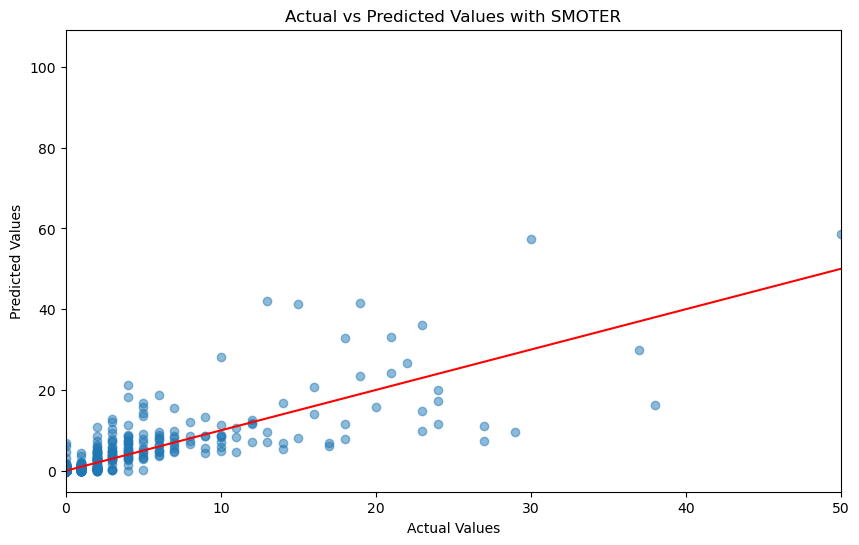

100%|===================| 19776/19783 [14:19<00:00]        

WITH SOCIAL WITH SMOTE
Test MAE: 0.433500243165482

Test MAE: 0.06714131807197248

Test MAE: 0.06766086801693115



In [10]:
#WITH SMOTE
#WITH SOCIAL
def train_evaluate_models(X_train, X_val, X_test, y_train, y_val, y_test):
    # Apply iterative SMOTE to the training set
    X_train, y_train = iterative_smote_regression_nonzero(X_train, y_train, k_neighbors=5, target_ratio=0.35, max_iterations=10, random_state=42)
    ridge_grid = {'alpha': [1,2,3,10]}
    rf_grid = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 7,10]
    }
    xgb_grid = {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.1, 0.2, 0.3, 0.4],
        'max_depth': [3 , 4, 6, 9]
    }
    # Initialize a dictionary to store results
    ridge_results = {}

# Iterate over the grid
    for alpha in ridge_grid['alpha']:
        ridge = Ridge(alpha=alpha)
        
        # Train the model
        ridge.fit(X_train, y_train)
        
        # Predict on the validation set
        y_val_pred = ridge.predict(X_val)
        
        # Calculate MAE
        mae = mean_absolute_error(y_val, y_val_pred)
    
    # Store results
        ridge_results[alpha] = mae
        # print(f'Alpha: {alpha}, Validation MAE: {mae}')

# Select the best hyperparameters
    best_ridge_alpha = min(ridge_results, key=ridge_results.get)
    print(f'Best Alpha for Ridge: {best_ridge_alpha}, Validation MAE: {ridge_results[best_ridge_alpha]}')

    from itertools import product

# Initialize a dictionary to store results
    rf_results = {}

    # Iterate over the grid
    for n_estimators, max_depth, min_samples_split in product(rf_grid['n_estimators'], rf_grid['max_depth'], rf_grid['min_samples_split']):
        params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split}
        rf = RandomForestRegressor(**params, random_state=42, n_jobs= -1)
        
        # Train the model
        rf.fit(X_train, y_train)
        
        # Predict on the validation set
        y_val_pred = rf.predict(X_val)
        
        # Calculate MAE
        mae = mean_absolute_error(y_val, y_val_pred)
        
        # Store results
        rf_results[str(params)] = mae
        # print(f'Params: {params}, Validation MAE: {mae}')

    # Select the best hyperparameters
    best_rf_params = min(rf_results, key=rf_results.get)
    print(f'Best Params for Random Forest: {best_rf_params}, Validation MAE: {rf_results[best_rf_params]}')
    
    # Initialize a dictionary to store results
    xgb_results = {}

    # Iterate over the grid
    for n_estimators, learning_rate, max_depth in product(xgb_grid['n_estimators'], xgb_grid['learning_rate'], xgb_grid['max_depth']):
        params = {'n_estimators': n_estimators, 'learning_rate': learning_rate, 'max_depth': max_depth}
        xgb_model = XGBRegressor(**params, random_state=42)
        
        # Train the model
        xgb_model.fit(X_train, y_train)
        
        # Predict on the validation set
        y_val_pred = xgb_model.predict(X_val)
        
        # Calculate MAE
        mae = mean_absolute_error(y_val, y_val_pred)
        
        # Store results
        xgb_results[str(params)] = mae
        # print(f'Params: {params}, Validation MAE: {mae}')

    # Select the best hyperparameters
    best_xgb_params = min(xgb_results, key=xgb_results.get)
    print(f'Best Params for XGBoost: {best_xgb_params}, Validation MAE: {xgb_results[best_xgb_params]}')



    # Train the Ridge model with the best alpha on the combined training and validation set
    ridge_best = Ridge(alpha=best_ridge_alpha)
    ridge_best.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

    # Predict on the test set
    y_test_pred_ridge = ridge_best.predict(X_test)

    # Calculate the MAE on the test set
    test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
    print(f'Test MAE with Best Alpha for Ridge: {test_mae_ridge}')
    
    # Train the Random Forest model with the best parameters on the combined training and validation set
    best_rf_params_eval = eval(best_rf_params)
    rf_best = RandomForestRegressor(**best_rf_params_eval, random_state=42)
    rf_best.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

    # Predict on the test set
    y_test_pred_rf = rf_best.predict(X_test)

    # Calculate the MAE on the test set
    test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
    print(f'Test MAE with Best Params for Random Forest: {test_mae_rf}')


    # Train the XGBoost model with the best parameters on the combined training and validation set
    best_xgb_params_eval = eval(best_xgb_params)
    xgb_best = XGBRegressor(**best_xgb_params_eval, random_state=42)
    xgb_best.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

    # Predict on the test set
    y_test_pred_xgb = xgb_best.predict(X_test)

    # Calculate the MAE on the test set
    test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
    print(f'Test MAE with Best Params for XGBoost: {test_mae_xgb}')
    
   

    results = {}
    
        
    results["Ridge"] = { 'model': 'Ridge', 'val_mae':ridge_results[best_ridge_alpha], 'test_mae': test_mae_ridge}
    results["Random Forest"] = {'model': 'Random Forest', 'val_mae': rf_results[best_rf_params], 'test_mae': test_mae_rf}
    results['XGBoost'] = {'model': 'XGBoost', 'val_mae': xgb_results[best_xgb_params], 'test_mae': test_mae_xgb}
        
        
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred_rf, alpha=0.5)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values with SMOTER')
    plt.xlim([0, 50])
    
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
    plt.show()

    explainer  = shap.TreeExplainer(rf_best, X_train)
    shap_values_1 = explainer(X_test, check_additivity = False)
    results['Random Forest']['shap_values'] = shap_values_1

    return results
# Load and preprocess data

df = load_preprocess_data("/Users/angeloszois/Desktop/Thesis/6M-0K-99K.users.dataset.public.csv")

# Split the data into features and target
X = df.drop(['productsSold'], axis=1)
y = df['productsSold']

# Split the data into train+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the train+validation set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Train and evaluate models
results= train_evaluate_models(X_train, X_val, X_test, y_train, y_val, y_test)

# Print results
print("WITH SOCIAL WITH SMOTE")
for model_name, result in results.items():
    print(f"Test MAE: {result['test_mae']}\n")

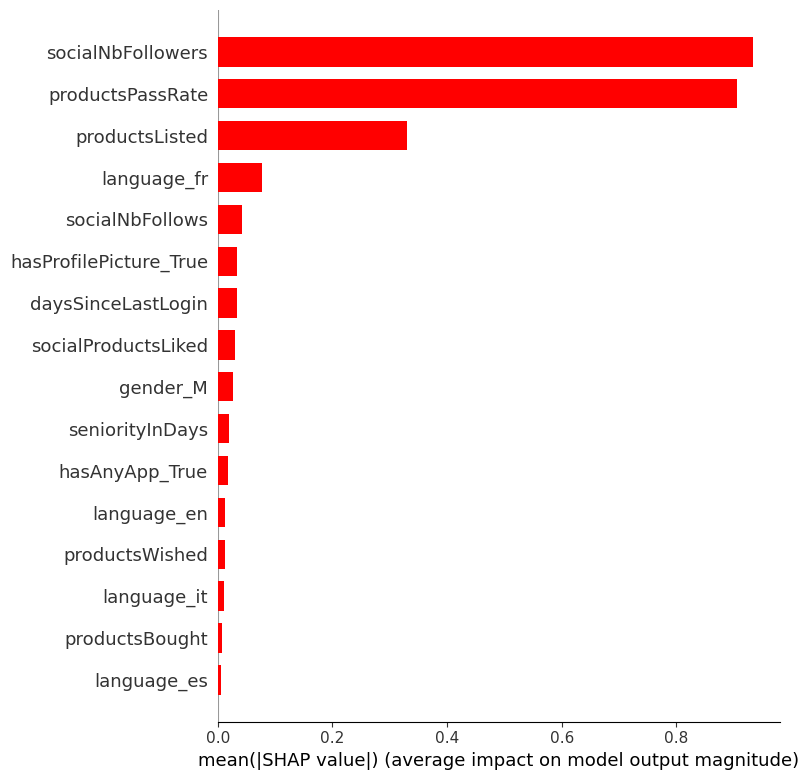

In [11]:

shap.summary_plot(results['Random Forest']['shap_values'].values, X_test, plot_type="bar", color= 'red')


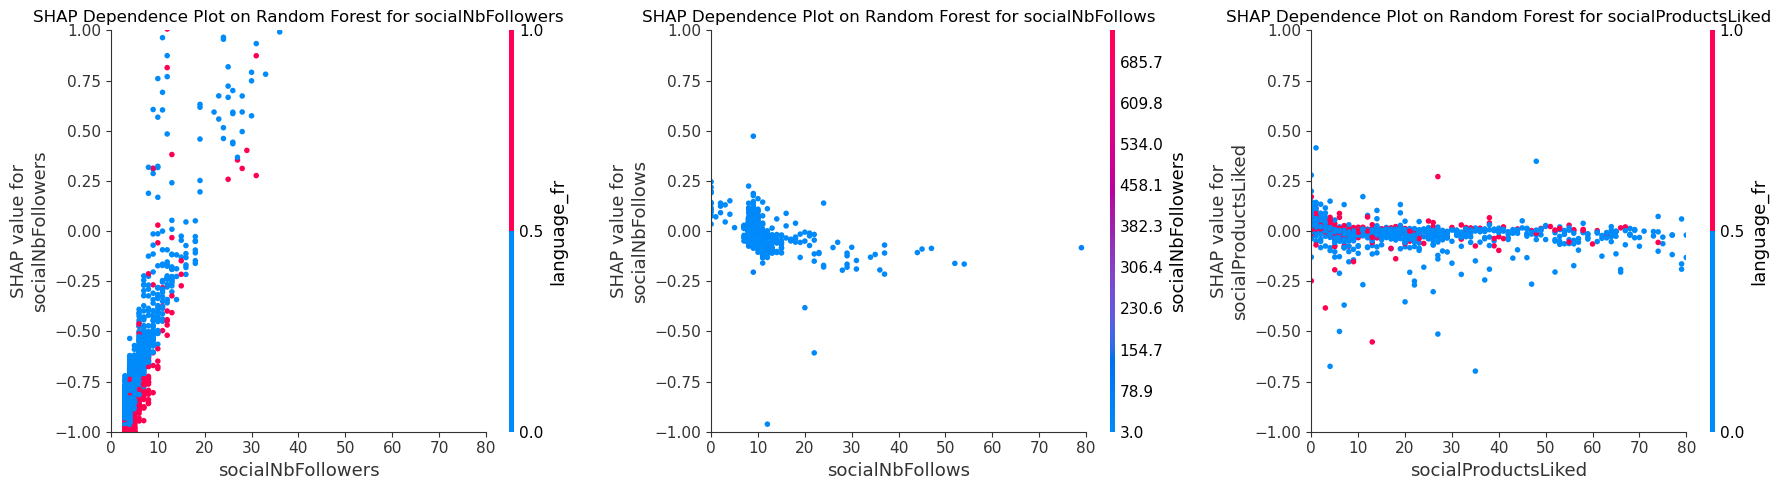

In [12]:
# Define the social features 
features_to_plot = ["socialNbFollowers", "socialNbFollows", "socialProductsLiked"]

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plot SHAP dependency plots for each feature only for Random Forest
for i, feature in enumerate(features_to_plot):
    shap.dependence_plot(feature, results['Random Forest']['shap_values'].values, X_test, ax=axes[i], show=False)
    axes[i].set_title(f'SHAP Dependence Plot on Random Forest for {feature}')
    if feature == 'socialNbFollowers':
            axes[i].set_xlim([0, 80])
            axes[i].set_ylim([-1, 1])
    elif feature == 'socialNbFollows':
            axes[i].set_xlim([0, 80])
            axes[i].set_ylim([-1, 1])
    elif feature == 'socialProductsLiked':
            axes[i].set_xlim([0, 80])
            axes[i].set_ylim([-1, 1])

plt.tight_layout()
plt.show()

In [14]:
#WITHOUT SMOTE 
#WITHOUT SOCIAL
def train_evaluate_models(X_train, X_val, X_test, y_train, y_val, y_test):
    
    ridge_grid = {'alpha': [1,2,3,10]}
    rf_grid = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 1, 10, 20],
        'min_samples_split': [2, 5, 7,10]
    }
    xgb_grid = {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [ 0.1, 0.2, 0.3, 0.4],
        'max_depth': [3, 4, 6, 9]
    }
    ridge_results = {}

# Iterate over the grid
    for alpha in ridge_grid['alpha']:
        ridge = Ridge(alpha=alpha)
        
        # Train the model
        ridge.fit(X_train, y_train)
        
        # Predict on the validation set
        y_val_pred = ridge.predict(X_val)
        
        # Calculate MAE
        mae = mean_absolute_error(y_val, y_val_pred)
    
    # Store results
        ridge_results[alpha] = mae
        # print(f'Alpha: {alpha}, Validation MAE: {mae}')

# Select the best hyperparameters
    best_ridge_alpha = min(ridge_results, key=ridge_results.get)
    print(f'Best Alpha for Ridge: {best_ridge_alpha}, Validation MAE: {ridge_results[best_ridge_alpha]}')

    from itertools import product

# Initialize a dictionary to store results
    rf_results = {}

    # Iterate over the grid
    for n_estimators, max_depth, min_samples_split in product(rf_grid['n_estimators'], rf_grid['max_depth'], rf_grid['min_samples_split']):
        params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split}
        rf = RandomForestRegressor(**params, random_state=42, n_jobs= -1)
        
        # Train the model
        rf.fit(X_train, y_train)
        
        # Predict on the validation set
        y_val_pred = rf.predict(X_val)
        
        # Calculate MAE
        mae = mean_absolute_error(y_val, y_val_pred)
        
        # Store results
        rf_results[str(params)] = mae
        # print(f'Params: {params}, Validation MAE: {mae}')

    # Select the best hyperparameters
    best_rf_params = min(rf_results, key=rf_results.get)
    print(f'Best Params for Random Forest: {best_rf_params}, Validation MAE: {rf_results[best_rf_params]}')
    
    # Initialize a dictionary to store results
    xgb_results = {}

    # Iterate over the grid
    for n_estimators, learning_rate, max_depth in product(xgb_grid['n_estimators'], xgb_grid['learning_rate'], xgb_grid['max_depth']):
        params = {'n_estimators': n_estimators, 'learning_rate': learning_rate, 'max_depth': max_depth}
        xgb_model = XGBRegressor(**params, random_state=42)
        
        # Train the model
        xgb_model.fit(X_train, y_train)
        
        # Predict on the validation set
        y_val_pred = xgb_model.predict(X_val)
        
        # Calculate MAE
        mae = mean_absolute_error(y_val, y_val_pred)
        
        # Store results
        xgb_results[str(params)] = mae
        # print(f'Params: {params}, Validation MAE: {mae}')

    # Select the best hyperparameters
    best_xgb_params = min(xgb_results, key=xgb_results.get)
    print(f'Best Params for XGBoost: {best_xgb_params}, Validation MAE: {xgb_results[best_xgb_params]}')



    # Train the Ridge model with the best alpha on the combined training and validation set
    ridge_best = Ridge(alpha=best_ridge_alpha)
    ridge_best.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

    # Predict on the test set
    y_test_pred_ridge = ridge_best.predict(X_test)

    # Calculate the MAE on the test set
    test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
    print(f'Test MAE with Best Alpha for Ridge: {test_mae_ridge}')
    
    # Train the Random Forest model with the best parameters on the combined training and validation set
    best_rf_params_eval = eval(best_rf_params)
    rf_best = RandomForestRegressor(**best_rf_params_eval, random_state=42)
    rf_best.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

    # Predict on the test set
    y_test_pred_rf = rf_best.predict(X_test)

    # Calculate the MAE on the test set
    test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
    print(f'Test MAE with Best Params for Random Forest: {test_mae_rf}')



    best_xgb_params_eval = eval(best_xgb_params)
    xgb_best = XGBRegressor(**best_xgb_params_eval, random_state=42)
    xgb_best.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

    # Predict on the test set
    y_test_pred_xgb = xgb_best.predict(X_test)

    # Calculate the MAE on the test set
    test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
    print(f'Test MAE with Best Params for XGBoost: {test_mae_xgb}')

    results = {}
    
        
    results["Ridge"] = { 'model': 'Ridge', 'val_mae':ridge_results[best_ridge_alpha], 'test_mae': test_mae_ridge}
    results["Random Forest"] = {'model': 'Random Forest', 'val_mae': rf_results[best_rf_params], 'test_mae': test_mae_rf}
    results['XGBoost'] = {'model': 'XGBoost', 'val_mae': xgb_results[best_xgb_params], 'test_mae': test_mae_xgb}
    return results
# Load and preprocess data

df = load_preprocess_data("/Users/angeloszois/Desktop/Thesis/6M-0K-99K.users.dataset.public.csv")

# Split the data into features and target
X = df.drop(['productsSold', "socialNbFollowers", "socialNbFollows", "socialProductsLiked"], axis=1)
y = df['productsSold']

# Split the data into train+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the train+validation set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Train and evaluate models
results3 = train_evaluate_models(X_train, X_val, X_test, y_train, y_val, y_test)

# Print results
print("WITHOUT SOCIAL WITHOUT SMOTE")
for model_name, result in results3.items():
    print(f"Test MAE: {result['test_mae']}\n")

Best Alpha for Ridge: 10, Validation MAE: 0.12679476728054237
Best Params for Random Forest: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 10}, Validation MAE: 0.08816785168683297
Best Params for XGBoost: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 9}, Validation MAE: 0.10125578585852373
Test MAE with Best Alpha for Ridge: 0.10336448151684464


/Users/angeloszois/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/angeloszois/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Test MAE with Best Params for Random Forest: 0.07537233226381193
Test MAE with Best Params for XGBoost: 0.08485295807668333
WITHOUT SOCIAL WITHOUT SMOTE
Test MAE: 0.10336448151684464

Test MAE: 0.07537233226381193

Test MAE: 0.08485295807668333



Best Alpha for Ridge: 10, Validation MAE: 0.2704766900366344
Best Params for Random Forest: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 5}, Validation MAE: 0.07765381659129927
Best Params for XGBoost: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 9}, Validation MAE: 0.08573105347780975
Test MAE with Best Alpha for Ridge: 0.255032862731928


/Users/angeloszois/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/angeloszois/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


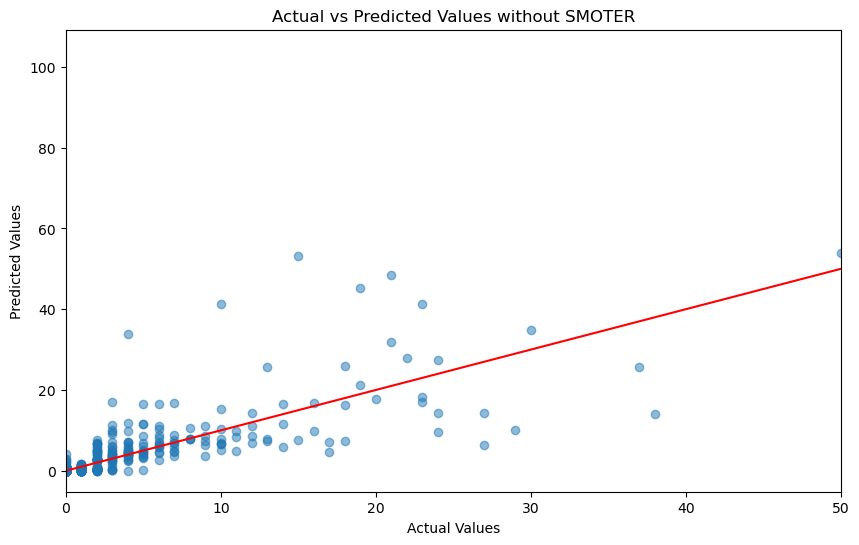

Test MAE with Best Params for Random Forest: 0.06182835313805954
Test MAE with Best Params for XGBoost: 0.06840445189645858
WITH SOCIAL WITHOUT SMOTE
Test MAE: 0.255032862731928

Test MAE: 0.06182835313805954

Test MAE: 0.06840445189645858



In [15]:
#WITH SOCIAL 
#WITHOUT SMOTE
def train_evaluate_models(X_train, X_val, X_test, y_train, y_val, y_test):
    ridge_grid = {'alpha': [1,2,3,10]}
    rf_grid = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 1, 10, 20],
        'min_samples_split': [2, 5, 7,10]
    }
    xgb_grid = {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [ 0.1, 0.2, 0.3, 0.4],
        'max_depth': [3, 4, 6, 9]
    }
    # Initialize a dictionary to store results
    ridge_results = {}

# Iterate over the grid
    for alpha in ridge_grid['alpha']:
        ridge = Ridge(alpha=alpha)
        
        # Train the model
        ridge.fit(X_train, y_train)
        
        # Predict on the validation set
        y_val_pred = ridge.predict(X_val)
        
        # Calculate MAE
        mae = mean_absolute_error(y_val, y_val_pred)
    
    # Store results
        ridge_results[alpha] = mae
        # print(f'Alpha: {alpha}, Validation MAE: {mae}')

# Select the best hyperparameters
    best_ridge_alpha = min(ridge_results, key=ridge_results.get)
    print(f'Best Alpha for Ridge: {best_ridge_alpha}, Validation MAE: {ridge_results[best_ridge_alpha]}')

    from itertools import product

# Initialize a dictionary to store results
    rf_results = {}

    # Iterate over the grid
    for n_estimators, max_depth, min_samples_split in product(rf_grid['n_estimators'], rf_grid['max_depth'], rf_grid['min_samples_split']):
        params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split}
        rf = RandomForestRegressor(**params, random_state=42, n_jobs= -1)
        
        # Train the model
        rf.fit(X_train, y_train)
        
        # Predict on the validation set
        y_val_pred = rf.predict(X_val)
        
        # Calculate MAE
        mae = mean_absolute_error(y_val, y_val_pred)
        
        # Store results
        rf_results[str(params)] = mae
        # print(f'Params: {params}, Validation MAE: {mae}')

    # Select the best hyperparameters
    best_rf_params = min(rf_results, key=rf_results.get)
    print(f'Best Params for Random Forest: {best_rf_params}, Validation MAE: {rf_results[best_rf_params]}')
    
    # Initialize a dictionary to store results
    xgb_results = {}

    # Iterate over the grid
    for n_estimators, learning_rate, max_depth in product(xgb_grid['n_estimators'], xgb_grid['learning_rate'], xgb_grid['max_depth']):
        params = {'n_estimators': n_estimators, 'learning_rate': learning_rate, 'max_depth': max_depth}
        xgb_model = XGBRegressor(**params, random_state=42)
        
        # Train the model
        xgb_model.fit(X_train, y_train)
        
        # Predict on the validation set
        y_val_pred = xgb_model.predict(X_val)
        
        # Calculate MAE
        mae = mean_absolute_error(y_val, y_val_pred)
        
        # Store results
        xgb_results[str(params)] = mae
        # print(f'Params: {params}, Validation MAE: {mae}')

    # Select the best hyperparameters
    best_xgb_params = min(xgb_results, key=xgb_results.get)
    print(f'Best Params for XGBoost: {best_xgb_params}, Validation MAE: {xgb_results[best_xgb_params]}')



    # Train the Ridge model with the best alpha on the combined training and validation set
    ridge_best = Ridge(alpha=best_ridge_alpha)
    ridge_best.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

    # Predict on the test set
    y_test_pred_ridge = ridge_best.predict(X_test)

    # Calculate the MAE on the test set
    test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
    print(f'Test MAE with Best Alpha for Ridge: {test_mae_ridge}')
    
    
    best_rf_params_eval = eval(best_rf_params)
    rf_best = RandomForestRegressor(**best_rf_params_eval, random_state=42)
    rf_best.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

    # Predict on the test set
    y_test_pred_rf = rf_best.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred_rf, alpha=0.5)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values without SMOTER')
    plt.xlim([0, 50])
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
    plt.show()
    residuals = y_test - y_test_pred_rf


    # Calculate the MAE on the test set
    test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
    print(f'Test MAE with Best Params for Random Forest: {test_mae_rf}')


    # Train the XGBoost model with the best parameters on the combined training and validation set
    best_xgb_params_eval = eval(best_xgb_params)
    xgb_best = XGBRegressor(**best_xgb_params_eval, random_state=42)
    xgb_best.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

    # Predict on the test set
    y_test_pred_xgb = xgb_best.predict(X_test)

    # Calculate the MAE on the test set
    test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
    print(f'Test MAE with Best Params for XGBoost: {test_mae_xgb}')

    results = {}
   
        
    results["Ridge"] = { 'model': 'Ridge', 'val_mae':ridge_results[best_ridge_alpha], 'test_mae': test_mae_ridge}
    results["Random Forest"] = {'model': 'Random Forest', 'val_mae': rf_results[best_rf_params], 'test_mae': test_mae_rf}
    results['XGBoost'] = {'model': 'XGBoost', 'val_mae': xgb_results[best_xgb_params], 'test_mae': test_mae_xgb}
    return results
# Load and preprocess data

df = load_preprocess_data("/Users/angeloszois/Desktop/Thesis/6M-0K-99K.users.dataset.public.csv")

# Split the data into features and target
X = df.drop(['productsSold'], axis=1)
y = df['productsSold']

# Split the data into train+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the train+validation set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Train and evaluate models
results4 = train_evaluate_models(X_train, X_val, X_test, y_train, y_val, y_test)

# Print results
print("WITH SOCIAL WITHOUT SMOTE")
for model_name, result in results4.items():
    print(f"Test MAE: {result['test_mae']}\n")

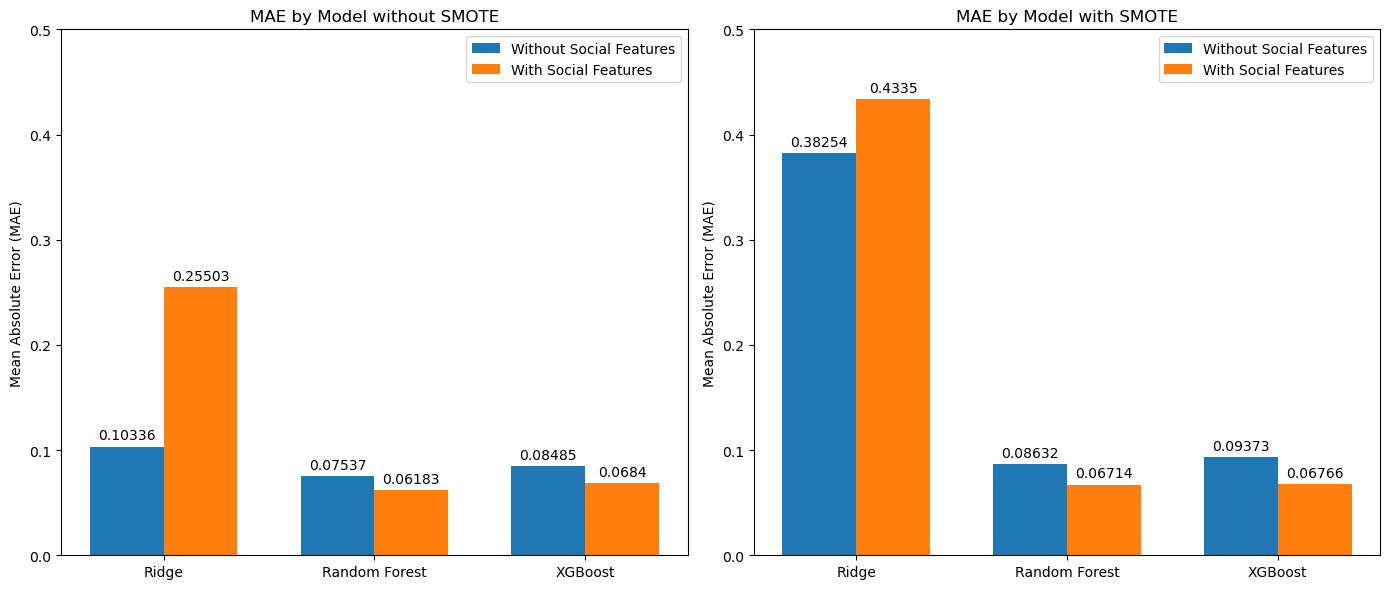

In [16]:
models = ['Ridge', 'Random Forest', 'XGBoost']
mae_without_social_without = [round(results3['Ridge']['test_mae'], 5), round(results3['Random Forest']['test_mae'], 5), round(results3['XGBoost']['test_mae'], 5)]  
mae_with_social_without = [round(results4['Ridge']['test_mae'], 5), round(results4['Random Forest']['test_mae'], 5), round(results4['XGBoost']['test_mae'], 5)]  
mae_without_social = [round(results1['Ridge']['test_mae'], 5), round(results1['Random Forest']['test_mae'], 5), round(results1['XGBoost']['test_mae'], 5)]  
mae_with_social = [round(results['Ridge']['test_mae'], 5), round(results['Random Forest']['test_mae'], 5), round(results['XGBoost']['test_mae'], 5)]  








# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  

# Data setup
x = list(range(len(models)))  
width = 0.35 

# First subplot: Without SMOTE
rects1 = ax1.bar([i - width/2 for i in x], mae_without_social_without, width, label='Without Social Features')
rects2 = ax1.bar([i + width/2 for i in x], mae_with_social_without, width, label='With Social Features')

ax1.set_ylabel('Mean Absolute Error (MAE)')
ax1.set_title('MAE by Model without SMOTE')
ax1.set_ylim([0, 0.5])
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.bar_label(rects1, padding=3)
ax1.bar_label(rects2, padding=3)

# Second subplot: With SMOTE
rects3 = ax2.bar([i - width/2 for i in x], mae_without_social, width, label='Without Social Features')
rects4 = ax2.bar([i + width/2 for i in x], mae_with_social, width, label='With Social Features')

ax2.set_ylabel('Mean Absolute Error (MAE)')
ax2.set_title('MAE by Model with SMOTE')
ax2.set_ylim([0, 0.5])
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.bar_label(rects3, padding=3)
ax2.bar_label(rects4, padding=3)

plt.tight_layout()
plt.show()


